# ZEMAX Rayfile Generation
---
### IQA
Far field focal length lens = 80mm

Near field magnification = 1


['100dc.txt', 'FF CW Row 1&2_0001.ascii.csv', 'FF CW Row 3&4_0001.ascii.csv', 'NF CW Row 1&2_0001.ascii.csv', 'NF CW Row 3&4_0001.ascii.csv']


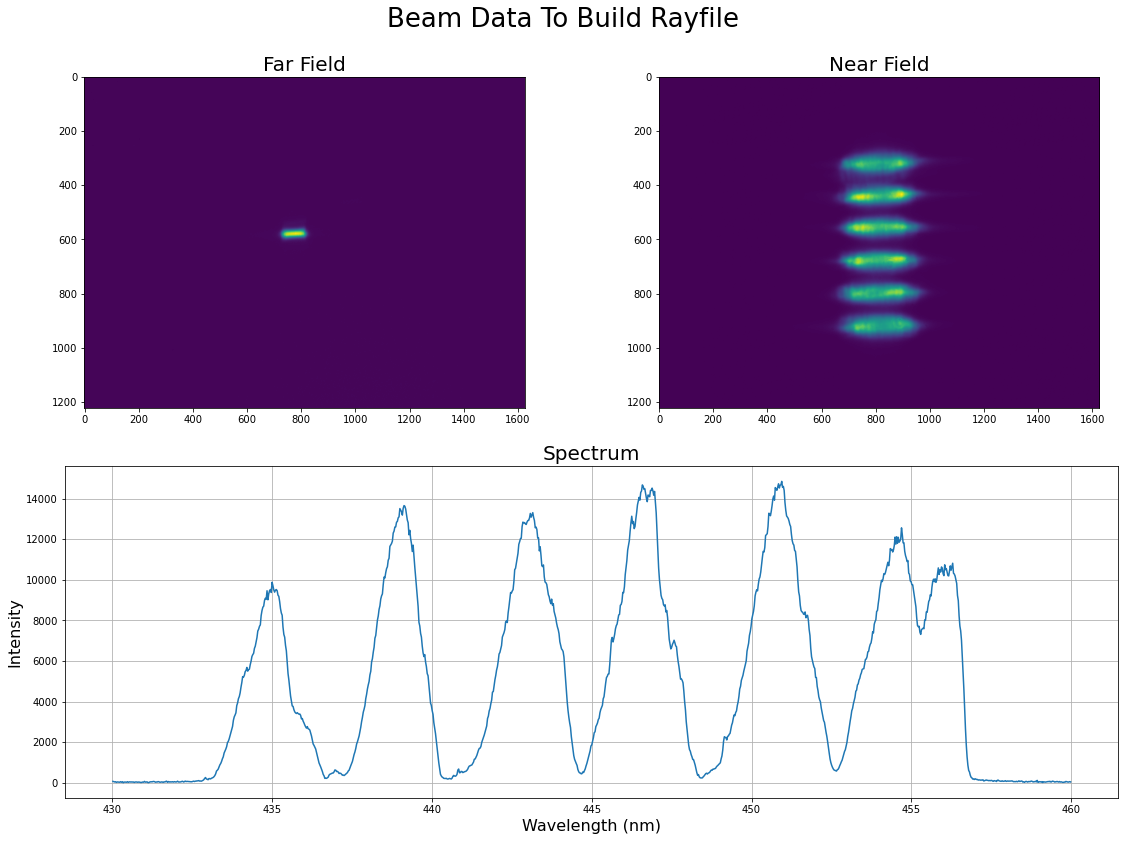

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys
sys.path.append('../') # Needed for import
import laserbeamtools as lbt

# Create a list of the files
folder = r'../tests/test_beam_profiles/For_Rayfile_Gen/22'
print(os.listdir(folder))

# Far field images
ff1_file = '/'.join([folder,r'FF CW Row 1&2_0001.ascii.csv'])
ff2_file = '/'.join([folder,r'FF CW Row 3&4_0001.ascii.csv'])

# Near field images
nf1_file = '/'.join([folder,r'NF CW Row 1&2_0001.ascii.csv'])
nf2_file = '/'.join([folder,r'NF CW Row 3&4_0001.ascii.csv'])

# Spectrum
spectrum_file = '/'.join([folder, r'100dc.txt'])

# Read spectrum method
def open_spectrum(file_name):
    x = []
    y = []
    with open(file_name,"r") as file:
        data=file.read()
        dataList = data.split('\n')
        for i in range(1,len(dataList)-1):
            temp = dataList[i].split('\t')
            x.append(float(temp[0]))
            y.append(float(temp[1]))
    x = np.asarray(x)
    y = np.asarray(y)
    return x, y

# Parse ASCII File
def parseAscii(filename):
    slens = []
    A = []
    with open(filename) as f:
        for rows in f:
            s = rows.split(',')
            slens.append(len(s))
        maxlen = max(slens)    
    with open(filename) as f:
        for rows in f:
            s1 = rows.strip('\n')
            s = s1.split(',')
            for i in range(0,maxlen):
                if (i >= len(s)):
                    s.append(0.0)
                elif (s[i] == ''):
                    s[i] = 0.0
                else:
                    s[i] = float(s[i])
                i = i+1
            A.append(s)
    B = np.array(A)
    return B

# generate lists
spec_x, spec_y = open_spectrum(spectrum_file)

# Trim spectrum file
indexs = (spec_x < 460) & (spec_x > 430)
spec_x_t = spec_x[indexs]
spec_y_t = spec_y[indexs]

# Generate Near Field Arrays
nf1 = parseAscii(nf1_file)
nf2 = parseAscii(nf2_file)

# Averaged image
nf = ((nf1/np.sum(nf1)) + (nf2/np.sum(nf2))) * 0.5

# Generate Far Field Arrays
ff1 = parseAscii(ff1_file)
ff2 = parseAscii(ff2_file)

# Averaged image
ff = ((ff1/np.sum(ff1)) + (ff2/np.sum(ff2))) * 0.5

# Plot data
fig = plt.figure(figsize=(16,12))

gs0 = gridspec.GridSpec(2, 1, figure=fig)
gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0])

ax1 = fig.add_subplot(gs00[0])
ax1.imshow(ff)
ax1.set_title('Far Field', fontsize=20)
# ax1.tick_params(labelbottom=False, labelleft=False)

ax2 = fig.add_subplot(gs00[1])
ax2.imshow(nf)
ax2.set_title('Near Field', fontsize=20)
# ax2.tick_params(labelbottom=False, labelleft=False)

ax3 = fig.add_subplot(gs0[1])
ax3.plot(spec_x_t, spec_y_t)
ax3.grid('on')
ax3.set_title('Spectrum', fontsize=20)
ax3.set_xlabel('Wavelength (nm)', fontsize = 16)
ax3.set_ylabel('Intensity', fontsize = 16)

plt.suptitle("Beam Data To Build Rayfile", fontsize = 26)
fig.tight_layout(pad=2)

plt.show()

# Crop And Center The Far Field Image
---
Run `beam_size()` to determine beam parameters.

Run `subtract_corner_background()` with `iso_noise=False` to subtract the background and zero all pixels below a certain threshold.

Run `crop_image_to_integration_rect()` to reduce the size of the image.

Must also verify that `beam_size()` found the correct parameters, this can be easily done by looking at the output of `plot_image_analysis()`.

`ff_c` is our new far field array. 

The center of the beam ellipse is at (773, 580)
The ellipse diameter (closest to horizontal) is 117 pixels
The ellipse diameter (closest to   vertical) is 53 pixels
The ellipse is rotated 3° ccw from the horizontal


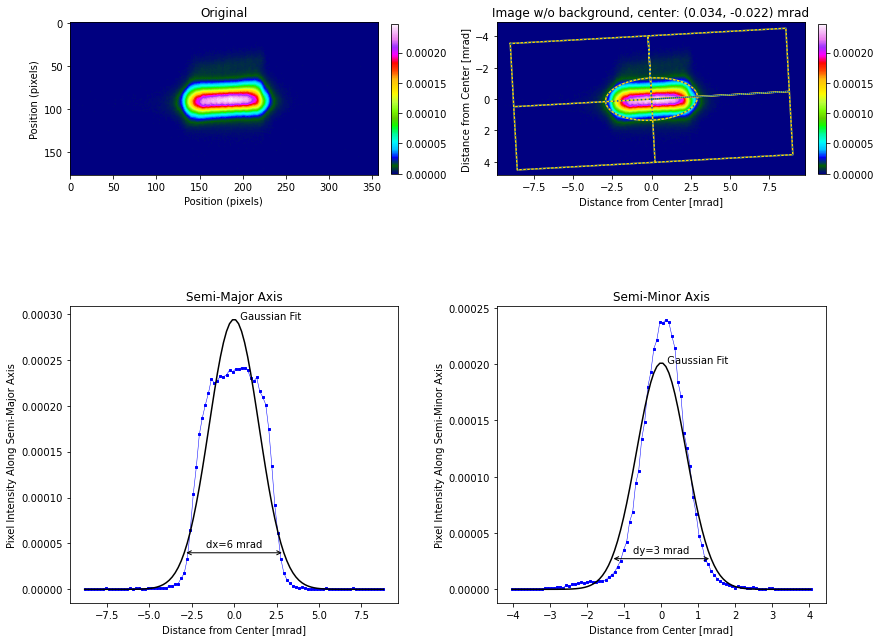

In [44]:
# Parse beam
x, y, dx, dy, phi = lbt.beam_size(ff)
print("The center of the beam ellipse is at (%.0f, %.0f)" % (x, y))
print("The ellipse diameter (closest to horizontal) is %.0f pixels" % dx)
print("The ellipse diameter (closest to   vertical) is %.0f pixels" % dy)
print("The ellipse is rotated %.0f° ccw from the horizontal" % (phi * 180/3.1416))

ff_nbg = lbt.subtract_corner_background(ff, iso_noise=False)

ff_c, ffx_c, ffy_c = lbt.crop_image_to_integration_rect(ff_nbg, x, y, dx, dy, phi)

flen = 80
pixel_size=4.4

lbt.plot_image_analysis(ff_c, pixel_size=pixel_size/flen, units='mrad')

# Crop And Center The Near Field
---
Repeat the same steps for near field image.

`nf_c` is our new near field array.

The center of the beam ellipse is at (812, 619)
The ellipse diameter (closest to horizontal) is 305 pixels
The ellipse diameter (closest to   vertical) is 823 pixels
The ellipse is rotated -0° ccw from the horizontal


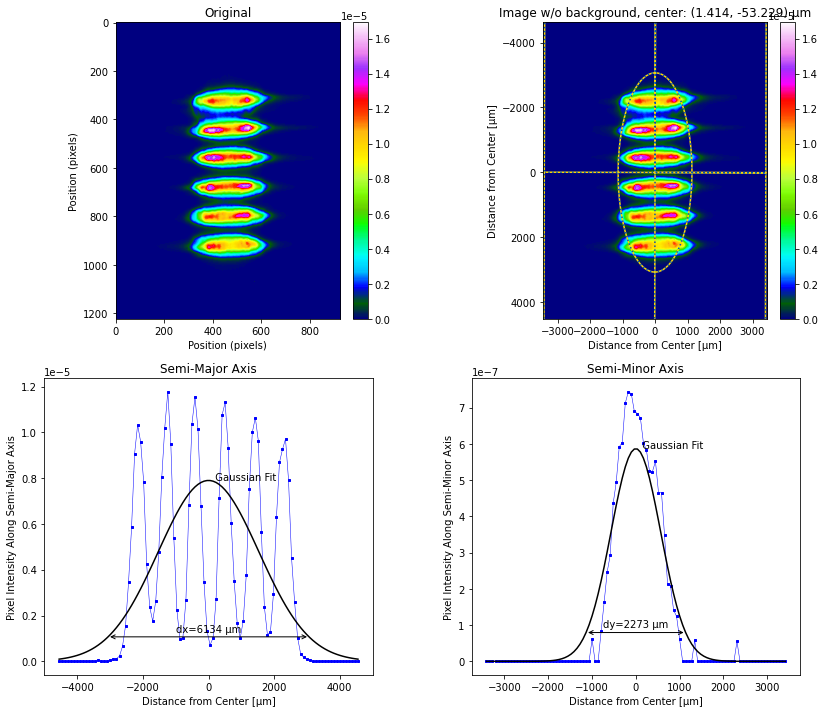

In [47]:
# Parse beam
x, y, dx, dy, phi = lbt.beam_size(nf)
print("The center of the beam ellipse is at (%.0f, %.0f)" % (x, y))
print("The ellipse diameter (closest to horizontal) is %.0f pixels" % dx)
print("The ellipse diameter (closest to   vertical) is %.0f pixels" % dy)
print("The ellipse is rotated %.0f° ccw from the horizontal" % (phi * 180/3.1416))

nf_nbg = lbt.subtract_corner_background(nf, iso_noise=False)

nf_c, nfx_c, nfy_c = lbt.crop_image_to_integration_rect(nf_nbg, x, y, dx, dy, phi)

pixel_size=4.4
mag = 0.59

lbt.plot_image_analysis(nf_c, pixel_size=pixel_size/mag)